In [1]:
# By Cristian Perez 
# By Christian Candido

In [2]:
# Data Manipulation
import numpy as np
import pandas as pd 

# LAS 
import laspy
import CSF

# Clustering
import hdbscan

# data visualization
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer # cluster visualizer
%matplotlib inline

# sklearn kmeans
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from pyclustering.cluster import cluster_visualizer
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.nnet.cnn import cnn_network, cnn_visualizer

In [4]:
file = r'C:/Users/pcuser/Documents/Acads/GmE 203/Project/LAS File/cloud.las' # Point Cloud 

In [5]:
las_file = laspy.read(file) # Read LAS File 
points = las_file.points # Access Point Cloud 
points

<ScaleAwarePointRecord(fmt: <PointFormat(2, 0 bytes of extra dims)>, len: 858253, point size: 26)>

In [6]:
point_format = las_file.point_format # Access properties of point clouds
list(point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'synthetic',
 'key_point',
 'withheld',
 'scan_angle_rank',
 'user_data',
 'point_source_id',
 'red',
 'green',
 'blue']

In [7]:
point_cloud = np.vstack((points.x, points.y, points.z)).transpose() # Extract X, Y, Z and put into a List 

In [8]:
csf = CSF.CSF()

# Parameter Setting
csf.params.bSloopSmooth = False
csf.params.cloth_resolution = 0.50 # more details about parameter: http://ramm.bnu.edu.cn/projects/CSF/download/

In [9]:
csf.setPointCloud(point_cloud)

ground = CSF.VecInt() # a list to indicate the index of ground points after calculation
non_ground = CSF.VecInt() # a list to indicate the index of non-ground points after calculation
csf.do_filtering(ground, non_ground)

In [85]:
outFile = laspy.LasData(las_file.header)
outFile.points = points[np.array(ground)] # extract non_ground points, and save it to a las file.

In [86]:
outFile.write(r"C:/Users/pcuser/Documents/Acads/GmE 203/Project/LAS File/out_ground.las")

: 

In [81]:
outPoint_format = outFile.point_format # Access properties of point clouds
list(outPoint_format.dimension_names)

outPoints = outFile.points

outPoint_cloud = np.vstack((outPoints.x, outPoints.y, outPoints.z, outPoints.red, outPoints.blue, outPoints.green)).transpose() # Extract X, Y, Z and put into a List 
# outPoint_cloud = np.vstack((outPoints.x, outPoints.y, outPoints.z)).transpose()
# outPoint_cloud = np.vstack((outPoints.red, outPoints.blue, outPoints.green)).transpose()

In [79]:
# Set-up parameter for HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=100)

# Cluster point clouds using HDBSCAN
labels = clusterer.fit_predict(outPoint_cloud)

In [80]:
len(np.unique(labels))

166

c:\Users\pcuser\mambaforge\envs\yolov5\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\pcuser\mambaforge\envs\yolov5\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\pcuser\mambaforge\envs\yolov5\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\pcuser\mambaforge\envs\yolov5\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


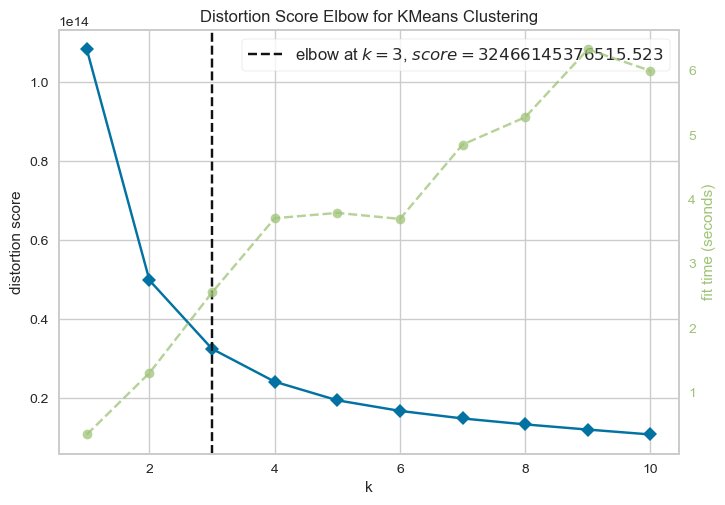

In [82]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11))

visualizer.fit(outPoint_cloud) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

In [83]:
# instatiate KMeans class and set the number of clusters
km_model = KMeans(n_clusters=3, random_state=10)

# call fit method with data 
km = km_model.fit_predict(outPoint_cloud)

# coordinates of cluster center
centroids = km_model.cluster_centers_ 

# cluster label for each data point
labels = km_model.labels_ 

c:\Users\pcuser\mambaforge\envs\yolov5\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [84]:
print ("No. of Clusters: ", len(np.unique(labels)))

3

In [49]:
# Create a new header for clustered label
header = laspy.LasHeader(point_format=3, version="1.2") 
header.add_extra_dim(laspy.ExtraBytesParams(name="Clusters", type=np.int32))

In [50]:
las = laspy.LasData(header)

las.x = outPoints.x     # x-coordinate
las.y = outPoints.y     # y-coordinate
las.z = outPoints.z     # z-coordinate
las.Clusters = labels   # clustered label
las.write(r"C:/Users/pcuser/Documents/Acads/GmE 203/Project/LAS File/classified_hdbscan_xyz_ground.las") # write las file 

In [39]:
del clusterer, labels, las